# Bioinformatics Project - Computational Drug Discovery - Influenza virus A matrix protein M2 - Extension - Influenza virus A Organism  
Michael Bahchevanov  
***

## Machine Learning Notebook 📔  
This is **Modelling Notebook** where we will be looking into optimizing and applying several machine learning techniques. We will be looking into a **RMT (Random Matrix Theory)** insprired model (that we have implemented as a part of the internal library). We will also be optimizing the **KNeighbours Regressor**. This will be done by using an **ANN** (Artificial Neural Network). Finally, we will be looking into **LSTM (Long short-term memory)** and whether it would provide better results than our regressor.
The goal of this notebook is to experiment with different ML techniques and find the most performing model on our extended dataset for the *Influenza virus A Organism*.

### 1. Random Matrix Theory Inspired Model 🎞

#### 1.1 Importing Libraries and Tooling 🧪  
For the **RMT** model we have implemented our own version of the algorithms inside our internal library. We will be using our internal **RMTClassifier** for modelling, **numpy** for computation, and **pandas** for data wrangling.

In [7]:
from lib.models import RMTClassifier
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

#### 1.2 Loading and splitting the data ✂  
We will be using **sklearn's** `train_test_split` for splitting our data into a 95-5 fashion (95% training, 5% testing). We have chosen that since we will be working with *2048* features (because of the **Morgan fingerprint vector** of length 2048) that would be outputting a single *pEC50* measurement.

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/influenza_05_morgan_matrix_fingerprint_pEC50.csv')
df_decoy = pd.read_csv('./data/5HT1A_02_morgan_matrix.csv')
df_decoy = df_decoy.to_numpy()
X = df.drop('pEC50', axis=1)
y = df['pEC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05, train_size=.95)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

#### 1.3 Training the model and evaluating the results 📝  
Firstly, we will train the model on our training dataset. Next, we are going to look into the *false positives* and *true positives* by looking into the *ROC Curve* (Receiver Operating Characteristic). The metric we will be using to evaluate our success would be the *AUC* (Area Under the ROC Curve).

In [3]:
clf = RMTClassifier()
clf.fit(X_train)

This function is going to run the classifier on both the decoy and the testing set.

In [4]:
def false_positive_true_positive(clf, multiple):
    test_preds = clf.predict(X_test, epsilon_multiple=multiple)
    decoy_preds = clf.predict(df_decoy, epsilon_multiple=multiple)
    tp = np.mean(test_preds)
    fp = np.mean(decoy_preds)
    return tp, fp

Now we are going to prepare the ***x*** - false positives and ***y*** - true positives.

In [5]:
x, y = [], []

for idx, val in enumerate(np.linspace(0.4,2,25)):
    if idx%3==0:
        print(f'progress:{(idx+1)* 4}%')
    fp, tp = false_positive_true_positive(clf, val)
    x.append(fp)
    y.append(tp)

progress:4%
progress:16%
progress:28%
progress:40%
progress:52%
progress:64%
progress:76%
progress:88%
progress:100%


Now we are going to import the *AUC* metric from *sklearn* and view our results.

In [6]:
from sklearn.metrics import auc

AUC = auc(x, y)
AUC = round(AUC, 2); AUC

0.38

Unfortunately, a result of *0.38* is unsatisfactory. Now we are going to visualize it to see why does it not work well.  
We are importing *matplotlib's* `pyplot` in order to visualize our results.

In [7]:
import matplotlib.pyplot as plt

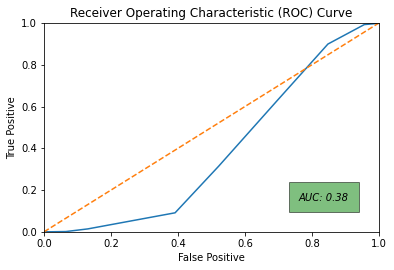

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.text(0.76, 0.15, f'AUC: {AUC}', style='italic', bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
ax.plot(x, y)
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.axis([0,1,0,1])
plt.show()

#### 1.4 Interpretation of the results ✔  
We have trained our model using the **RMT Classifier** with very little success. The model proved to not yield good results for our case. The model predicted the correct results hardly ever with the majority of the predictions falling below the *ROC Curve*.  
The next model we are going to try would be a *neural network regressor*.

### 2. Neural Network Regressor 🧠

#### 2.1 Importing Libraries and Tooling 🧪  
For this model we will be using *keras* -  a high-level deep learning library. We will also be optimizing our model using *sklearn's* tooling. The measurement of success would be a low **RMSE** score.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold

#### 2.2 Feature Selection 🔎

Firstly, we are going to select only the features with significant variance and drop the low variance ones.

In [10]:
transformer = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train, X_test = transformer.fit_transform(X_train), transformer.transform(X_test)

In [11]:
X_train.shape

(864, 28)

#### 2.3 Model Optimization ⚙

We will be training a linear model that has 3 dense and 1 droupout layer. The first layer is going to hold the features from the **Morgan vector** and the final layer is going to output our **pEC50** value. The dropout layer is going to serve as our over-fitting measure. The neural network is going to be built around the *keras* wrapper for *scikit-learn*. We will be performing *GridSearchCV* for cross-validation looking into different activation functions, neuron numbers, and optimizers.

In [12]:
def baseline_model(activation = 'relu', neurons=64, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation, kernel_initializer='normal'))
    model.add(Dense(neurons, activation=activation, kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    return model

activation = ['softmax', 'relu', 'linear']
neurons = [64, 128, 256, 512, 1024, 2048]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasRegressor(build_fn= baseline_model, epochs= 25, batch_size=10, verbose=10)

model = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)
model.fit(X_train, y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Max Accuracy Registred: -1.023 using {'activation': 'relu', 'neurons': 1024, 'optimizer': 'Adamax'}


#### 2.4 Model Building and Predictions 🔬  
We will be building our model based on the output of our optimization. The metric we are going to measure our success would be the **RMSE**.

In [13]:
def baseline_model(activation = 'relu', neurons=512, optimizer='Adamax'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation, kernel_initializer='normal'))
    model.add(Dense(neurons, activation=activation, kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    return model

clf = KerasRegressor(build_fn= baseline_model, epochs= 25, batch_size=10, verbose=0)
clf.fit(X_train, y_train)

In [14]:
y_hat = clf.predict(X_test)
y_hat

array([6.9799104, 4.0294147, 4.643439 , 4.7793145, 3.79398  , 5.1208763,
       4.5518575, 6.9799104, 5.0600343, 4.7793145, 7.6063585, 4.454056 ,
       4.8163276, 4.988112 , 4.589399 , 4.7793145, 9.926537 , 5.735807 ,
       7.38298  , 5.3473496, 4.2378426, 5.7982163, 6.041553 , 4.6962776,
       4.858948 , 5.740765 , 3.9535346, 4.6345243, 6.594248 , 4.589399 ,
       4.5212855, 5.131845 , 5.513848 , 6.526545 , 4.8407407, 5.550877 ,
       5.1892858, 5.947947 , 3.9535346, 6.608484 , 5.9796386, 4.629523 ,
       5.346094 , 5.255527 , 5.291648 , 6.185536 ], dtype=float32)

In [15]:
'RMSE score: {:.2f}'.format(clf.score(X_test, y_test))

'RMSE score: -1.23'

#### 2.5 Visualization and Interpretation 📈

<function matplotlib.pyplot.show(close=None, block=None)>

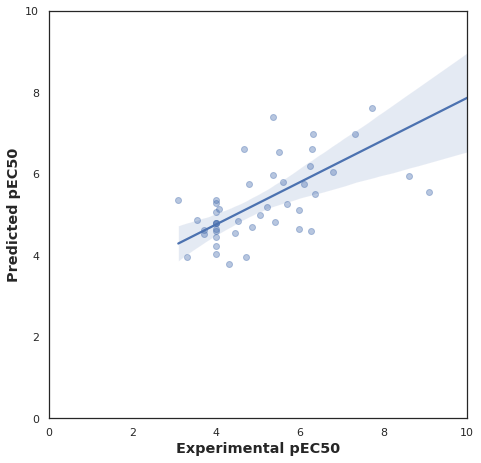

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style('white')

ax = sns.regplot(y_test, y_hat, scatter_kws={'alpha': 0.4})
ax.set_xlabel('Experimental pEC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pEC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.figure.set_size_inches(7.5, 7.5)
plt.show

Overall, we can see that the results are not particularly satisfactory. The regressor does not follow the trend well and with a score of *-1.16* for a logarithmic value, that would not yield good predictions.

### 3. KNeighbors Regressor 🎎  
For this model, we will be using *sklearn's* `KNeighborsRegressor`. We will be further optimizing the model using `GridSearchCV` where we will be looking into the different combinations of:  
* n_neighbors  
* weights  
* leaf_size  
* p value

#### 3.1 Importing Libraries and Tooling 🧪  
For this model we will be using *sklearn's* `KNeighborsRegressor` so we will be importing that.

In [17]:
from sklearn.neighbors import KNeighborsRegressor

#### 3.2 Model Optimization ⚙  
We will be optimizing the regressor with a different set of the *n_neighbors*, *weights*, *leaf_size*, and *p* hyperparameters. We will be using `GridSearchCV` to cross-validate the results.

In [18]:
n_neighbors = np.arange(5, 380, 25)
weights = ['uniform', 'distance']
leaf_size = np.arange(30, 30*10, 30)
p = np.linspace(2.0, 4.0, num=10)
param_grid_n=dict(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p)

neigh = KNeighborsRegressor()

cv = GridSearchCV(estimator=neigh, param_grid=param_grid_n, n_jobs=-1, verbose=0)
cv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': array([ 30,  60,  90, 120, 150, 180, 210, 240, 270]),
                         'n_neighbors': array([  5,  30,  55,  80, 105, 130, 155, 180, 205, 230, 255, 280, 305,
       330, 355]),
                         'p': array([2.        , 2.22222222, 2.44444444, 2.66666667, 2.88888889,
       3.11111111, 3.33333333, 3.55555556, 3.77777778, 4.        ]),
                         'weights': ['uniform', 'distance']})

In [19]:
cv.best_params_

{'leaf_size': 180, 'n_neighbors': 30, 'p': 2.0, 'weights': 'distance'}

We can see that our best model uses the following parameters:
* leaf_size - 180  
* n_neighbors - 30  
* p - 2.0  
* weights - distance

#### 3.3 Model Building and Predictions 🔬  
We will be building our model based on the output of our optimization. The metric we are going to measure our success would be the **coefficient of determination (R$^{2}$)**.

In [20]:
clf = KNeighborsRegressor(leaf_size=180, n_neighbors=30, p=2, weights='distance')
clf.fit(X_train, y_train)

KNeighborsRegressor(leaf_size=180, n_neighbors=30, weights='distance')

In [21]:
y_hat = clf.predict(X_test)
y_hat

array([6.70889013, 4.        , 4.18980287, 4.89977061, 4.21193265,
       5.05729262, 4.05551733, 6.70889013, 4.92218894, 4.89977061,
       7.40911318, 4.        , 4.65814601, 5.09691001, 4.89794001,
       4.89977061, 9.38866762, 5.57268251, 7.70215402, 5.41495705,
       4.        , 5.814586  , 6.32990001, 5.042109  , 5.18311889,
       4.84216386, 3.53293846, 4.652168  , 6.36668534, 4.89794001,
       4.61880393, 4.82665018, 5.67957805, 5.81254638, 4.48203419,
       6.37472699, 5.76499735, 5.6730117 , 3.53293846, 5.87026279,
       5.59024287, 4.33025167, 4.69897   , 5.06103129, 4.52287875,
       6.10334564])

In [22]:
r2 = clf.score(X_test, y_test)
r2

0.5664406204771189

#### 3.4 Visualization and Interpretation 📈

<function matplotlib.pyplot.show(close=None, block=None)>

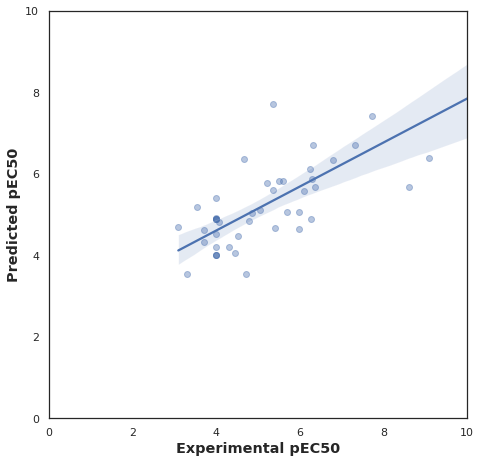

In [23]:
ax = sns.regplot(y_test, y_hat, scatter_kws={'alpha': 0.4})
ax.set_xlabel('Experimental pEC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pEC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.figure.set_size_inches(7.5, 7.5)
plt.show

Overall, this model provides satisfactory results, as it has moderate positive R$^{2}$ score and follows the trend. (or at least better than our *neural network regressor*). This model could be used for further drug discovery.

## Conclusion  
From our modelling experiments, we found a suitable model that could predict a possible bioactive compound that would inhibit our target (*Influenza virus A Organism*) - *KNeighbors Regressor*. These models are by no means suited for production and do not provide significant results. Causes of the results may be due to:
* process execution  
* quality of the data  
* quantity of the data  
* possible little bioavailability of the compounds
***  
The process we have gone through shows that some methods are better than others, but overall the usage of any of these models should not be taken as a ground truth as the they are relatively off by a moderate/large margin.

***  
## EXTRA  
### 1. Generation of a molecule based on SMILES with LSTM  
In this extra of this notebook, we will be attempting to generate a molecularly similar compound based on an already discovered bioactive compound against the *Influenza virus A*. This drug is called ***Amantadine*** which is a clinically and historically proven compound that is used for treatment and prevention of the virus' infection. We will be using a **RNN (Recurrent Neural Network) - LSTM (Long short-term memory)**. 

In [71]:
import sys
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
%matplotlib inline

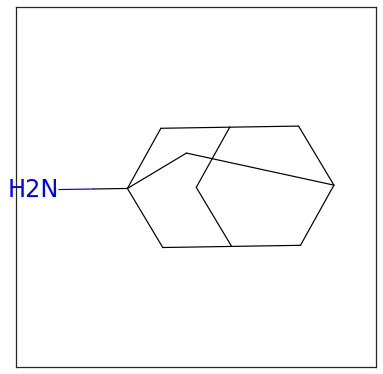

In [25]:
amantadine_smiles = 'C1C2CC3CC1CC(C2)(C3)N'
amantadine = Chem.MolFromSmiles(amantadine_smiles)

Draw.MolToMPL(amantadine, size=(200, 200));

This is the molecule of the *amantadine* which is a cyclohexane with the *NH$_{2}$* amine group.

#### 1.1 Cleaning the SMILES data for all molecularly similar compounds

Firstly, we will be loading in the ***SMILES*** notation of *2936* compounds with a structure, similar to the one of the *Amantadine*.

In [76]:
file_path = './data/CID_2130_compound.csv'
df = pd.read_csv(file_path)
df = df.filter(['mf'])
smiles_raw = df.to_numpy().reshape(-1)
smiles_raw

array(['CCCC(C12CC3CC(C1)CC(C3)C2)N', 'CC12CC3CC(C1)(CC(C3)(C2)C(=O)NO)C',
       'CC12CC3CC(C1)(CC(C3)(C2)N)C', ..., 'C1C2CC3CC1CC(C2)(C3)N(N)Cl',
       'CC12CC3CC(C1Cl)(CC(C3)(C2)N)C',
       'CC(C)(C)NC12CC3CC(C1)CC(C3)(C2)O'], dtype=object)

Now we are going to use a NLP (Natural Language Processing) technique that maps characters to a numeric representation and a reverse map that maps a numeric representation back to characters. We also need to ensure that the length of the mapping and the reverse mapping are the same.

In [86]:
unique_chars = sorted(list(set(smiles_raw)))
mapping = dict((c, i) for i, c in enumerate(unique_chars))
mapping.update({-1 : "\n"})
reverse_mapping = dict((i, c) for i, c in enumerate(unique_chars))
reverse_mapping.update({"\n" : -1})
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)

assert mapping_size == reverse_mapping_size

In [87]:
n_chars = len(smiles)
n_vocab = len(unique_chars)
n_chars, n_vocab, mapping_size

(2936, 2758, 2759)

Now we are going to prepare datasets by matching the dataset lengths. For `dataX` will be the *SMILES* strings and for `dataY` will be the individual characters in the *SMILES* string. We will also be using **5%** of our data for validation and **95%** for training.

In [89]:
seq_length = int(n_vocab * 0.05)
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)

In [90]:
len(dataX), len(dataY), len(raw_text)

(2799, 2799, 2936)

Now we will be reshaping our matrix in the dimensions required to create a ***LSTM*** neural network ([samples, time_steps, features]). We are also going to normalize the integers by dividing each of them with the number of unique *SMILES* characters. (in our case - the vocabulary)

In [19]:
X = np.reshape(dataX, (n_patterns, seq_length, 1))
X = X / float(n_vocab)

We will also turn our numerical representation of the vocabulary characters to a categorical variable.

In [91]:
Y = np_utils.to_categorical(dataY)

#### 1.2 Building the LSTM 🔨  
For this neural network, we will be building a multi-layer LSTM. Each layer has decreasing amount of neurons per hidden layer. The model is not fully optimized but as a general rule of thumb, the more neurons, the higher the performance but longer the computation time. The activation function would be *softmax* as to produce the probability (between 0 and 1) of a specific molecule in the structure.

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1], activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 137, 128)          66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 137, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 137, 256)          394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 137, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 137, 512)          1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 137, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 137, 256)         

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

As the model would take a long time to train, and my hardware is perfectly suited for heavy computations, we will be using checkpoints to train the model. We will start with a bigger batch size and decrease the batch size every other training session (which drastically increases the computation time but provides a better accuracy).

In [34]:
filepath="./data/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

model.fit(X, Y, epochs = 19, batch_size = 512, callbacks = callbacks_list)

Epoch 1/19
6/6 [==============================] - 219s 18s/step - loss: 7.9233

Epoch 00001: loss improved from inf to 7.92370, saving model to ./data/weights-improvement-01-7.9237.hdf5
Epoch 2/19
6/6 [==============================] - 86s 13s/step - loss: 7.9236

Epoch 00002: loss improved from 7.92370 to 7.92283, saving model to ./data/weights-improvement-02-7.9228.hdf5
Epoch 3/19
6/6 [==============================] - 112s 13s/step - loss: 7.9240

Epoch 00003: loss did not improve from 7.92283
Epoch 4/19
6/6 [==============================] - 85s 14s/step - loss: 7.9319

Epoch 00004: loss did not improve from 7.92283
Epoch 5/19
6/6 [==============================] - 86s 14s/step - loss: 7.9245

Epoch 00005: loss did not improve from 7.92283
Epoch 6/19
6/6 [==============================] - 83s 14s/step - loss: 7.9210

Epoch 00006: loss improved from 7.92283 to 7.92231, saving model to ./data/weights-improvement-06-7.9223.hdf5
Epoch 7/19
6/6 [==============================] - 77s 12s

For saving the optimized weights, we will be saving them in the *.hdf5* file format, which is used to store and organize large amount of data.

In [64]:
model_path = './data/weights-improvement-19-7.8648.hdf5'
model = load_model(model_path)

At this point the training times could not be handled well by my machine, so I have decided to cut it to a loss of *7.8648* which is okay but it could be better with more computational power.

In [95]:
# checkpoint = ModelCheckpoint(file_path, monitor='less', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# latest_model.fit(X, Y, epochs = 50, batch_size=64, callbacks=callbacks_list)

#### 1.3 Molecule Generation via the model 🧪  
We have trained and loaded the model. Now our goal is to "come up" with a molecule of a similar structure to the one of *Amantadine*.  
Firstly, we will induce some randomness in the generation as to come up with different molecules each time we want to generate one. So we will be selecting a starting index by using randomness. The seed that comes from that index would serve as our pattern.

In [67]:
start = np.random.randint(0, len(dataX) - 1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

Seed:
" C1C2C(CC2(F)F)(CN1)NCC(=C)N1C2CC3CC1CC(C3)(C2)FCC1C2CCCC1(C(CC2)O)NC1C2CC3CC(C2)(CC1C3N=O)ClCC(=C)C12CC3CC(C1)C(=C)C(C3)C2C1C2CC3CC1CC(C2)N(C3)NCC(CC1C2CC3CC(C2)CC1C3)ClCC1CC2(C1CC(C2)N)NC1C2CC3(CC4CC2(C3)C1C(=O)O4)NCC1(CC2CCCC(=C1)C2)NC1C2CC1C(C3CC2C3)NCNC1CCC2CCCC23C1CC3CN1C=NOC12C3CC4CC2CN(C4)C3CCCCC12CC3CCC(C1)CC(C3)(C2)CC1C2CC3(CC1C[N+](C2)(C3)CN)OC1C2CC3(CC1CC(C2)(C3)C(=O)N)CNC1C2CC3CC1C(C(C2)C3=O)OCClCC(C12CC3CC(C1)CC(C3)C2)[SiH](O)OCC(=O)S(=O)C12CC3CC(C1)CC(C3)C2C1CC23CCCC24CC5CC(C4)CC3(C1)C5C=C1C2CC3CC4(C2)CC1(C3)C4CC1C2CC3CC(C2)CC1(C3)O[SiH](C)CC1C2CN3CC1(CN(C2)N3)NC1C2CC3CC(C2)(CC1CC3N=O)OC1C2CC3C4C1C5CC(C4)C3C5C2CC(C)C1(C2CC3CC1CC(C3)(C2)C)CC1CC2C3C1C4CC(C3)CC2C4CNC1C2CC3CC(C2)(CC1C(C3N=O)N=O)ClCC12CC3CC(C1)(CC(C3)(C2)[SiH3])CC1C2CC3CN(C2)CC1CC3OC=OCC1=NC2(C3CC4CC2CN(C4)C3)ON1CC1CC2(CC3C2C1CC3)CCC12CC3C14C(C3)(CC4(C2)O)OCC1CC2(CC3CC(C2)CC1C3)CCC(C12CC3CC(C1)CC(C3)C2)OCC1C2CC3CC1CC(C2)C(C3N=O)N=OCC12CC3CC(C1)CC(C3)(C2)C(C)(C)CCC12CC3CC(C1)CC(C3)(C2)C=OC1C2CC3(CC1CC(C

Now that we have the seed, we are going to use our model to predict a *SMILES* of a molecule.

In [116]:
x = np.reshape(pattern, (1, len(pattern), 1))
prediction = model.predict(x, verbose=0)
index = np.argmax(prediction)
result = int_to_char[index]

In [117]:
result

'CC12CC3CC(C1)(CC(C3)(C2)N)C'

This is the molecule our model has "synthesized". In fact, the molecule we have generated, actually does exist. (<a href="https://www.ebi.ac.uk/pdbe-srv/pdbechem/chemicalCompound/show/377">Source</a>)  
We can further prove that by generating a molecule from the *SMILES* notation.

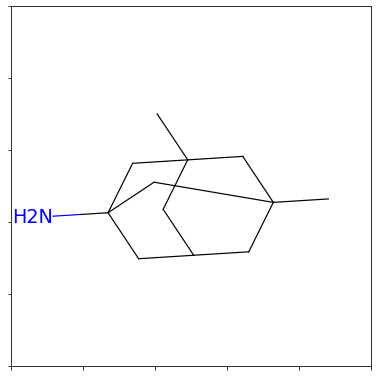

In [119]:
new_smiles = result
new_smiles = Chem.MolFromSmiles(result)

Draw.MolToMPL(new_smiles, size=(200, 200));

## Overview  
In this extra piece of experimentation, we tried to synthesize a new molecule - a compound similar to the current best known drug against the *Influenza virus A* - ***Amantadine***. We have successfully generated a molecule after we trained a *LSTM* neural network. Although the drug already exists, it was still a really cool experiment.